# Data load n Preprocessing

In [ ]:
!pip install opendatasets
import opendatasets as od
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from transformers import pipeline
import torch
import torchvision
import opendatasets as od
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import AutoImageProcessor, AutoModel
from keras.applications.efficientnet import preprocess_input
# from datasets import load_dataset
# import keras_tuner as kt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from distutils.dir_util import copy_tree
SEED_VALUE = 1234
np.random.seed(SEED_VALUE)
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [ ]:
od.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/data")

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


100%|██████████| 778M/778M [00:03<00:00, 264MB/s]


In [ ]:
base_dir = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset'

source_dirs = ['Normal', 'Viral Pneumonia', 'COVID']
input_dir = './train'
output_dir = './test'

normal_dir = f'{base_dir}/Normal/images'
viral_dir = f'{base_dir}/Viral Pneumonia/images'
covid_dir = f'{base_dir}/COVID/images'

In [ ]:
import shutil
train_dir = './train'
val_dir   = './val'
test_dir  = './test'

classes = ['COVID', 'Normal', 'Viral Pneumonia']

for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)
    for c in classes:
        os.makedirs(os.path.join(d, c), exist_ok=True)
filepaths = []
labels = []

for c in classes:
    folder = os.path.join(base_dir, c, 'images')
    images = [os.path.join(folder, x) for x in os.listdir(folder) if x.lower().endswith(('png','jpg','jpeg'))]

    filepaths.extend(images)
    labels.extend([c] * len(images))

print("Total images:", len(filepaths))

# Stratified split
train_files, temp_files, train_labels, temp_labels = train_test_split(
    filepaths, labels, test_size=0.3, stratify=labels, random_state=42
)


val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)


def copy_files(files, labels, target_dir):
    for f, lbl in zip(files, labels):
        shutil.copy(f, os.path.join(target_dir, lbl))

# Copy to folders
copy_files(train_files, train_labels, train_dir)
copy_files(val_files, val_labels, val_dir)
copy_files(test_files, test_labels, test_dir)

Total images: 15153


In [ ]:
import os
from collections import Counter

def count_images(folder):
    counts = {}
    for cls in sorted(os.listdir(folder)):
        cls_path = os.path.join(folder, cls)
        if os.path.isdir(cls_path):
            imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(('png','jpg','jpeg'))]
            counts[cls] = len(imgs)
    return counts

train_counts = count_images('./train')
val_counts = count_images('./val')
test_counts = count_images('./test')

print("TRAIN:", train_counts)
print("VAL:", val_counts)
print("TEST:", test_counts)


TRAIN: {'COVID': 2531, 'Normal': 7134, 'Viral Pneumonia': 942}
VAL: {'COVID': 542, 'Normal': 1529, 'Viral Pneumonia': 202}
TEST: {'COVID': 543, 'Normal': 1529, 'Viral Pneumonia': 201}


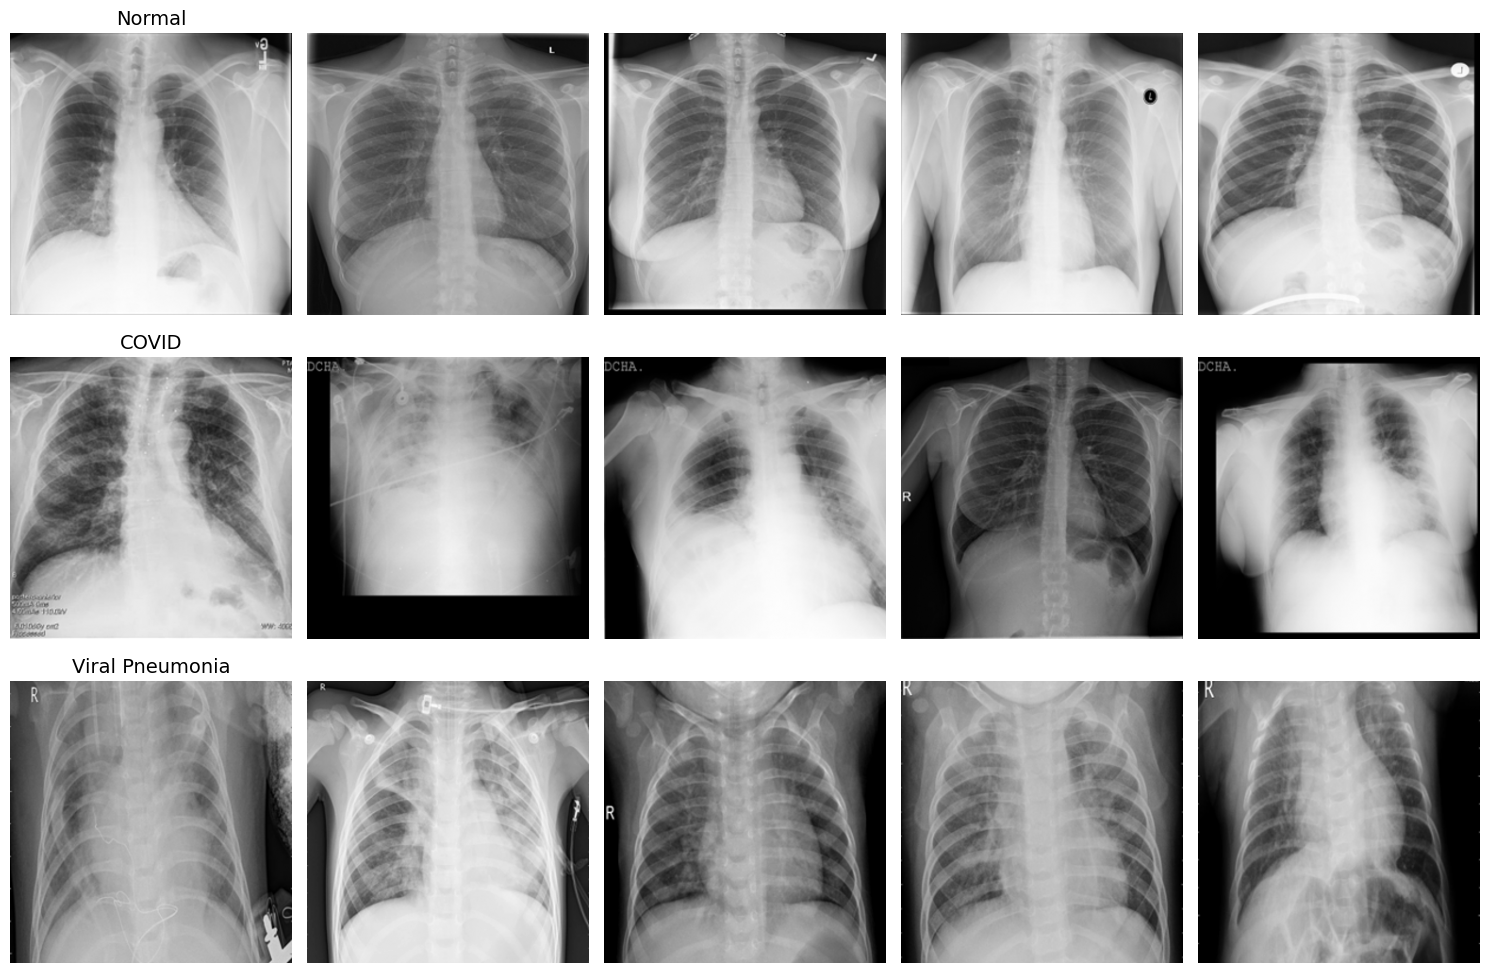

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

def show_samples(base_dir='./train', classes=['Normal', 'COVID', 'Viral Pneumonia'], n=5):
    plt.figure(figsize=(15, 10))

    for i, cls in enumerate(classes):
        cls_dir = os.path.join(base_dir, cls)
        images = [f for f in os.listdir(cls_dir) if f.lower().endswith(('png','jpg','jpeg'))]

        sample_imgs = images[:n]

        for j, img_name in enumerate(sample_imgs):
            img_path = os.path.join(cls_dir, img_name)
            img = Image.open(img_path)

            # plot
            ax = plt.subplot(len(classes), n, i*n + j + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            if j == 0:
                ax.set_title(cls, fontsize=14)

    plt.tight_layout()
    plt.show()

show_samples()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import preprocess_input as dense_preprocess

train_datagen = ImageDataGenerator(
    preprocessing_function=dense_preprocess,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1]
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=dense_preprocess
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    './train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    './val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    './test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 10607 images belonging to 3 classes.
Found 2273 images belonging to 3 classes.
Found 2273 images belonging to 3 classes.


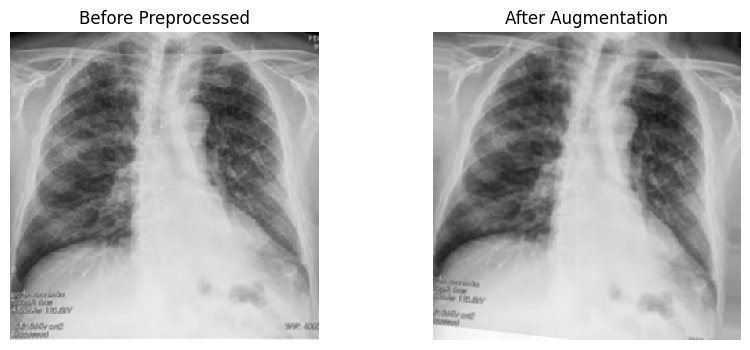

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt


sample_class = list(train_generator.class_indices.keys())[0]
sample_path = os.path.join('./train', sample_class, os.listdir(os.path.join('./train', sample_class))[0])

img = load_img(sample_path, target_size=(224,224))
x = img_to_array(img)

# Before
x_before = preprocess_input(x.copy())

# After (apply augmentation + preprocess_input)
x_after = train_datagen.random_transform(x.copy())
x_after = preprocess_input(x_after)

def normalize_for_plot(arr):
    arr = (arr - arr.min()) / (arr.max() - arr.min())
    return arr

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(normalize_for_plot(x_before))
plt.title("Before Preprocessed")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(normalize_for_plot(x_after))
plt.title("After Augmentation")
plt.axis("off")

plt.show()


# Testing model

# densenet 169

In [ ]:
from tensorflow.keras.applications import DenseNet169
base_model = DenseNet169(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=(224, 224, 3)
)

base_model.trainable = True

In [ ]:
x = base_model.output
outputs = layers.Dense(3, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 12,647,875 (48.25 MB)

 Trainable params: 12,489,475 (47.64 MB)

 Non-trainable params: 158,400 (618.75 KB)

In [ ]:
#Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7
)

checkpoint = ModelCheckpoint(
    'best_densenet169.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
epochs = 20

history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8780 - loss: 0.2958
Epoch 1: val_loss improved from inf to 0.14205, saving model to best_densenet169.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 775s 1s/step - accuracy: 0.8782 - loss: 0.2955 - val_accuracy: 0.9450 - val_loss: 0.1421 - learning_rate: 1.0000e-04
Epoch 2/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.9750 - loss: 0.0745
Epoch 2: val_loss improved from 0.14205 to 0.05577, saving model to best_densenet169.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 213s 642ms/step - accuracy: 0.9750 - loss: 0.0745 - val_accuracy: 0.9828 - val_loss: 0.0558 - learning_rate: 1.0000e-04
Epoch 3/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.9804 - loss: 0.0518
Epoch 3: val_loss did not improve from 0.05577
332/332 ━━━━━━━━━━━━━━━━━━━━ 211s 635ms/step - accuracy: 0.9804 - loss: 0.0518 - val_accuracy: 0.9714 - val_loss: 0.0704 - learning_rate: 1.0000e-04
Epoch 4/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.9889 - loss: 0.0343
Epoch 4: val_loss did not improve from 0.05577
332/332 ━━━━━━━━━━━━━━━━━━━━ 266s 800ms/step - accuracy: 0.9889 - loss: 0.0343 - val_accuracy: 0.9815 - val_loss: 0.0610 - learning_rate: 1.0000e-04
Epoch 5/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9901 - loss: 0.0277
Epoch 5: val_loss improved from 0.05577 to 0.03107, saving model to best_densenet169.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 242s 730ms/step - accuracy: 0.9901 - loss: 0.0277 - val_accuracy: 0.9903 - val_loss: 0.0311 - learning_rate: 5.0000e-05
Epoch 6/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.9956 - loss: 0.0145
Epoch 6: val_loss did not improve from 0.03107
332/332 ━━━━━━━━━━━━━━━━━━━━ 209s 630ms/step - accuracy: 0.9956 - loss: 0.0145 - val_accuracy: 0.9820 - val_loss: 0.0503 - learning_rate: 5.0000e-05
Epoch 7/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.9962 - loss: 0.0141
Epoch 7: val_loss did not improve from 0.03107
332/332 ━━━━━━━━━━━━━━━━━━━━ 210s 633ms/step - accuracy: 0.9962 - loss: 0.0141 - val_accuracy: 0.9868 - val_loss: 0.0379 - learning_rate: 5.0000e-05
Epoch 8/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.9977 - loss: 0.0090
Epoch 8: val_loss did not improve from 0.03107
332/332 ━━━━━━━━━━━━━━━━━━━━ 266s 646ms/step - accuracy: 0.9977 - loss: 0.0090 - val_accuracy: 0.9872 - val_loss: 0.0417 - learning_rate: 2.5000e-05

332/332 ━━━━━━━━━━━━━━━━━━━━ 217s 654ms/step - accuracy: 0.9982 - loss: 0.0075 - val_accuracy: 0.9925 - val_loss: 0.0230 - learning_rate: 2.5000e-05
Epoch 10/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.9982 - loss: 0.0066
Epoch 10: val_loss did not improve from 0.02301
332/332 ━━━━━━━━━━━━━━━━━━━━ 214s 645ms/step - accuracy: 0.9982 - loss: 0.0066 - val_accuracy: 0.9934 - val_loss: 0.0238 - learning_rate: 2.5000e-05
Epoch 11/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.9991 - loss: 0.0043
Epoch 11: val_loss did not improve from 0.02301
332/332 ━━━━━━━━━━━━━━━━━━━━ 213s 639ms/step - accuracy: 0.9991 - loss: 0.0043 - val_accuracy: 0.9842 - val_loss: 0.0508 - learning_rate: 2.5000e-05
Epoch 12/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.9982 - loss: 0.0049
Epoch 12: val_loss did not improve from 0.02301
332/332 ━━━━━━━━━━━━━━━━━━━━ 214s 644ms/step - accuracy: 0.9982 - loss: 0.0049 - val_accuracy: 0.9850 - val_loss: 0.0477 - learning_rate: 1.25

# ResNet50

In [ ]:
from keras.applications.resnet50 import preprocess_input as resnet_preprocess

train_datagen_resnet = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1]
)

val_test_datagen_resnet = ImageDataGenerator(
    preprocessing_function=resnet_preprocess
)

In [ ]:
train_generator_resnet = train_datagen_resnet.flow_from_directory(
    './train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator_resnet = val_test_datagen_resnet.flow_from_directory(
    './val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator_resnet = val_test_datagen_resnet.flow_from_directory(
    './test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 10607 images belonging to 3 classes.
Found 2273 images belonging to 3 classes.
Found 2273 images belonging to 3 classes.


In [ ]:
base_model_resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=(224, 224, 3)
)

base_model_resnet.trainable = True

In [ ]:
x = base_model_resnet.output
outputs = layers.Dense(3, activation='softmax')(x)

model2 = models.Model(inputs=base_model_resnet.input, outputs=outputs)
model2.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 23,540,739 (89.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
checkpoint_resnet = ModelCheckpoint(
    'best_resnet50.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [ ]:
model2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
epochs = 20

history2 = model2.fit(
    train_generator_resnet,
    validation_data=val_generator_resnet,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr, checkpoint_resnet],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.9043 - loss: 0.2499
Epoch 1: val_loss improved from inf to 0.32803, saving model to best_resnet50.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 297s 680ms/step - accuracy: 0.9044 - loss: 0.2496 - val_accuracy: 0.8667 - val_loss: 0.3280 - learning_rate: 1.0000e-04
Epoch 2/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.9709 - loss: 0.0854
Epoch 2: val_loss improved from 0.32803 to 0.15966, saving model to best_resnet50.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 197s 592ms/step - accuracy: 0.9710 - loss: 0.0854 - val_accuracy: 0.9384 - val_loss: 0.1597 - learning_rate: 1.0000e-04
Epoch 3/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.9832 - loss: 0.0525
Epoch 3: val_loss improved from 0.15966 to 0.09663, saving model to best_resnet50.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 201s 590ms/step - accuracy: 0.9832 - loss: 0.0525 - val_accuracy: 0.9670 - val_loss: 0.0966 - learning_rate: 1.0000e-04
Epoch 4/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.9847 - loss: 0.0438
Epoch 4: val_loss did not improve from 0.09663
332/332 ━━━━━━━━━━━━━━━━━━━━ 192s 576ms/step - accuracy: 0.9847 - loss: 0.0438 - val_accuracy: 0.7739 - val_loss: 0.5877 - learning_rate: 1.0000e-04
Epoch 5/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.9862 - loss: 0.0377
Epoch 5: val_loss did not improve from 0.09663
332/332 ━━━━━━━━━━━━━━━━━━━━ 190s 571ms/step - accuracy: 0.9862 - loss: 0.0377 - val_accuracy: 0.9472 - val_loss: 0.1331 - learning_rate: 1.0000e-04
Epoch 6/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.9914 - loss: 0.0263
Epoch 6: val_loss improved from 0.09663 to 0.04520, saving model to best_resnet50.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 196s 588ms/step - accuracy: 0.9915 - loss: 0.0263 - val_accuracy: 0.9846 - val_loss: 0.0452 - learning_rate: 5.0000e-05
Epoch 7/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.9959 - loss: 0.0131
Epoch 7: val_loss did not improve from 0.04520
332/332 ━━━━━━━━━━━━━━━━━━━━ 194s 582ms/step - accuracy: 0.9959 - loss: 0.0131 - val_accuracy: 0.9806 - val_loss: 0.0572 - learning_rate: 5.0000e-05
Epoch 8/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.9943 - loss: 0.0171
Epoch 8: val_loss did not improve from 0.04520
332/332 ━━━━━━━━━━━━━━━━━━━━ 191s 574ms/step - accuracy: 0.9943 - loss: 0.0171 - val_accuracy: 0.8777 - val_loss: 0.3610 - learning_rate: 5.0000e-05
Epoch 9/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.9955 - loss: 0.0132
Epoch 9: val_loss improved from 0.04520 to 0.03646, saving model to best_resnet50.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 197s 594ms/step - accuracy: 0.9955 - loss: 0.0131 - val_accuracy: 0.9859 - val_loss: 0.0365 - learning_rate: 2.5000e-05
Epoch 10/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.9976 - loss: 0.0078
Epoch 10: val_loss did not improve from 0.03646
332/332 ━━━━━━━━━━━━━━━━━━━━ 193s 579ms/step - accuracy: 0.9976 - loss: 0.0078 - val_accuracy: 0.9872 - val_loss: 0.0388 - learning_rate: 2.5000e-05
Epoch 11/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.9976 - loss: 0.0072
Epoch 11: val_loss did not improve from 0.03646
332/332 ━━━━━━━━━━━━━━━━━━━━ 193s 580ms/step - accuracy: 0.9976 - loss: 0.0072 - val_accuracy: 0.9331 - val_loss: 0.1925 - learning_rate: 2.5000e-05
Epoch 12/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.9986 - loss: 0.0052
Epoch 12: val_loss improved from 0.03646 to 0.03433, saving model to best_resnet50.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 196s 591ms/step - accuracy: 0.9986 - loss: 0.0052 - val_accuracy: 0.9899 - val_loss: 0.0343 - learning_rate: 1.2500e-05
Epoch 13/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.9994 - loss: 0.0030
Epoch 13: val_loss improved from 0.03433 to 0.03219, saving model to best_resnet50.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 197s 592ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.9916 - val_loss: 0.0322 - learning_rate: 1.2500e-05
Epoch 14/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.9992 - loss: 0.0032
Epoch 14: val_loss did not improve from 0.03219
332/332 ━━━━━━━━━━━━━━━━━━━━ 191s 573ms/step - accuracy: 0.9992 - loss: 0.0032 - val_accuracy: 0.9916 - val_loss: 0.0331 - learning_rate: 1.2500e-05
Epoch 15/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.9988 - loss: 0.0033
Epoch 15: val_loss improved from 0.03219 to 0.03135, saving model to best_resnet50.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 198s 597ms/step - accuracy: 0.9988 - loss: 0.0033 - val_accuracy: 0.9903 - val_loss: 0.0314 - learning_rate: 1.2500e-05
Epoch 16/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.9993 - loss: 0.0030
Epoch 16: val_loss did not improve from 0.03135
332/332 ━━━━━━━━━━━━━━━━━━━━ 191s 576ms/step - accuracy: 0.9993 - loss: 0.0030 - val_accuracy: 0.9912 - val_loss: 0.0317 - learning_rate: 1.2500e-05
Epoch 17/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.9989 - loss: 0.0033
Epoch 17: val_loss did not improve from 0.03135
332/332 ━━━━━━━━━━━━━━━━━━━━ 191s 575ms/step - accuracy: 0.9989 - loss: 0.0033 - val_accuracy: 0.9881 - val_loss: 0.0474 - learning_rate: 1.2500e-05
Epoch 18/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.9979 - loss: 0.0053
Epoch 18: val_loss did not improve from 0.03135
332/332 ━━━━━━━━━━━━━━━━━━━━ 190s 571ms/step - accuracy: 0.9979 - loss: 0.0053 - val_accuracy: 0.9833 - val_loss: 0.0594 - learning_rate: 6.25

# MobileNetV2

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobile_preprocess

In [ ]:
train_datagen_mobile = ImageDataGenerator(
    preprocessing_function=mobile_preprocess,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1]
)

val_test_datagen_mobile = ImageDataGenerator(
    preprocessing_function=mobile_preprocess
)

In [ ]:
train_generator_mobile = train_datagen_mobile.flow_from_directory(
    './train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator_mobile = val_test_datagen_mobile.flow_from_directory(
    './val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator_mobile = val_test_datagen_mobile.flow_from_directory(
    './test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 10607 images belonging to 3 classes.
Found 2273 images belonging to 3 classes.
Found 2273 images belonging to 3 classes.


In [ ]:
base_model_mobile = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model_mobile.trainable = True

In [ ]:
x = base_model_mobile.output
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(3, activation='softmax')(x)

model3 = models.Model(inputs=base_model_mobile.input, outputs=outputs)
model3.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 2,227,715 (8.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
checkpoint_mobile = ModelCheckpoint(
    'best_mobilenetv2.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [ ]:
model3.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
epochs = 20

history3 = model3.fit(
    train_generator_mobile,
    validation_data=val_generator_mobile,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr, checkpoint_mobile],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.8770 - loss: 0.3136
Epoch 1: val_loss improved from inf to 1.78685, saving model to best_mobilenetv2.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 265s 626ms/step - accuracy: 0.8771 - loss: 0.3132 - val_accuracy: 0.4496 - val_loss: 1.7869 - learning_rate: 1.0000e-04
Epoch 2/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.9703 - loss: 0.0939
Epoch 2: val_loss improved from 1.78685 to 1.38792, saving model to best_mobilenetv2.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 162s 489ms/step - accuracy: 0.9703 - loss: 0.0939 - val_accuracy: 0.5935 - val_loss: 1.3879 - learning_rate: 1.0000e-04
Epoch 3/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9792 - loss: 0.0619
Epoch 3: val_loss improved from 1.38792 to 1.32309, saving model to best_mobilenetv2.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 163s 490ms/step - accuracy: 0.9792 - loss: 0.0619 - val_accuracy: 0.6454 - val_loss: 1.3231 - learning_rate: 1.0000e-04
Epoch 4/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9798 - loss: 0.0537
Epoch 4: val_loss improved from 1.32309 to 0.81368, saving model to best_mobilenetv2.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 162s 489ms/step - accuracy: 0.9798 - loss: 0.0537 - val_accuracy: 0.7334 - val_loss: 0.8137 - learning_rate: 1.0000e-04
Epoch 5/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9852 - loss: 0.0427
Epoch 5: val_loss improved from 0.81368 to 0.74226, saving model to best_mobilenetv2.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 162s 487ms/step - accuracy: 0.9852 - loss: 0.0428 - val_accuracy: 0.7492 - val_loss: 0.7423 - learning_rate: 1.0000e-04
Epoch 6/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.9893 - loss: 0.0323
Epoch 6: val_loss improved from 0.74226 to 0.28835, saving model to best_mobilenetv2.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 160s 481ms/step - accuracy: 0.9893 - loss: 0.0323 - val_accuracy: 0.8874 - val_loss: 0.2884 - learning_rate: 1.0000e-04
Epoch 7/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.9898 - loss: 0.0290
Epoch 7: val_loss did not improve from 0.28835
332/332 ━━━━━━━━━━━━━━━━━━━━ 162s 487ms/step - accuracy: 0.9898 - loss: 0.0291 - val_accuracy: 0.8117 - val_loss: 0.4645 - learning_rate: 1.0000e-04
Epoch 8/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9893 - loss: 0.0299
Epoch 8: val_loss did not improve from 0.28835
332/332 ━━━━━━━━━━━━━━━━━━━━ 159s 479ms/step - accuracy: 0.9893 - loss: 0.0299 - val_accuracy: 0.8363 - val_loss: 0.4101 - learning_rate: 1.0000e-04
Epoch 9/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.9939 - loss: 0.0207
Epoch 9: val_loss did not improve from 0.28835
332/332 ━━━━━━━━━━━━━━━━━━━━ 161s 483ms/step - accuracy: 0.9939 - loss: 0.0207 - val_accuracy: 0.6978 - val_loss: 0.8547 - learning_rate: 5.0000e-05

332/332 ━━━━━━━━━━━━━━━━━━━━ 160s 481ms/step - accuracy: 0.9966 - loss: 0.0133 - val_accuracy: 0.9274 - val_loss: 0.1911 - learning_rate: 2.5000e-05
Epoch 12/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9960 - loss: 0.0107
Epoch 12: val_loss improved from 0.19108 to 0.16276, saving model to best_mobilenetv2.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 158s 476ms/step - accuracy: 0.9960 - loss: 0.0107 - val_accuracy: 0.9340 - val_loss: 0.1628 - learning_rate: 2.5000e-05
Epoch 13/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9969 - loss: 0.0105
Epoch 13: val_loss improved from 0.16276 to 0.16145, saving model to best_mobilenetv2.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 159s 478ms/step - accuracy: 0.9969 - loss: 0.0105 - val_accuracy: 0.9380 - val_loss: 0.1614 - learning_rate: 2.5000e-05
Epoch 14/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9987 - loss: 0.0060
Epoch 14: val_loss improved from 0.16145 to 0.08931, saving model to best_mobilenetv2.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 159s 478ms/step - accuracy: 0.9987 - loss: 0.0060 - val_accuracy: 0.9679 - val_loss: 0.0893 - learning_rate: 2.5000e-05
Epoch 15/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9974 - loss: 0.0080
Epoch 15: val_loss improved from 0.08931 to 0.05670, saving model to best_mobilenetv2.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 161s 485ms/step - accuracy: 0.9974 - loss: 0.0080 - val_accuracy: 0.9811 - val_loss: 0.0567 - learning_rate: 2.5000e-05
Epoch 16/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.9975 - loss: 0.0080
Epoch 16: val_loss did not improve from 0.05670
332/332 ━━━━━━━━━━━━━━━━━━━━ 165s 496ms/step - accuracy: 0.9975 - loss: 0.0080 - val_accuracy: 0.9639 - val_loss: 0.0960 - learning_rate: 2.5000e-05
Epoch 17/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9985 - loss: 0.0049
Epoch 17: val_loss improved from 0.05670 to 0.04553, saving model to best_mobilenetv2.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 162s 487ms/step - accuracy: 0.9984 - loss: 0.0049 - val_accuracy: 0.9864 - val_loss: 0.0455 - learning_rate: 2.5000e-05
Epoch 18/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.9977 - loss: 0.0072
Epoch 18: val_loss did not improve from 0.04553
332/332 ━━━━━━━━━━━━━━━━━━━━ 163s 492ms/step - accuracy: 0.9977 - loss: 0.0072 - val_accuracy: 0.9820 - val_loss: 0.0503 - learning_rate: 2.5000e-05
Epoch 19/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.9984 - loss: 0.0062
Epoch 19: val_loss did not improve from 0.04553
332/332 ━━━━━━━━━━━━━━━━━━━━ 165s 497ms/step - accuracy: 0.9984 - loss: 0.0062 - val_accuracy: 0.9745 - val_loss: 0.0718 - learning_rate: 2.5000e-05
Epoch 20/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.9972 - loss: 0.0089
Epoch 20: val_loss did not improve from 0.04553
332/332 ━━━━━━━━━━━━━━━━━━━━ 163s 489ms/step - accuracy: 0.9972 - loss: 0.0089 - val_accuracy: 0.9767 - val_loss: 0.0663 - learning_rate: 1.25

# EfficientNetB0


In [ ]:
from keras.applications.efficientnet import preprocess_input as effnet_preprocess
train_datagen_effnet = ImageDataGenerator(
    preprocessing_function=effnet_preprocess,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1]
)

val_test_datagen_effnet = ImageDataGenerator(
    preprocessing_function=effnet_preprocess
)

In [ ]:
train_generator_effnet = train_datagen_effnet.flow_from_directory(
    './train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator_effnet = val_test_datagen_effnet.flow_from_directory(
    './val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator_effnet = val_test_datagen_effnet.flow_from_directory(
    './test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 10607 images belonging to 3 classes.
Found 2273 images belonging to 3 classes.
Found 2273 images belonging to 3 classes.


In [ ]:
base_model_effnet = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model_effnet.trainable = True

In [ ]:
checkpoint_effnet = ModelCheckpoint(
    'best_effnetb0.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [ ]:
x = base_model_effnet.output
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(3, activation='softmax')(x)

model4 = models.Model(inputs=base_model_effnet.input, outputs=outputs)
model4.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_7[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 4,011,391 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
model4.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
epochs = 20

history4 = model4.fit(
    train_generator_effnet,
    validation_data=val_generator_effnet,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr, checkpoint_effnet],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - accuracy: 0.8506 - loss: 0.4116
Epoch 1: val_loss improved from inf to 0.19954, saving model to best_effnetb0.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 368s 801ms/step - accuracy: 0.8508 - loss: 0.4110 - val_accuracy: 0.9204 - val_loss: 0.1995 - learning_rate: 1.0000e-04
Epoch 2/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9652 - loss: 0.0956
Epoch 2: val_loss improved from 0.19954 to 0.07651, saving model to best_effnetb0.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 177s 532ms/step - accuracy: 0.9652 - loss: 0.0956 - val_accuracy: 0.9745 - val_loss: 0.0765 - learning_rate: 1.0000e-04
Epoch 3/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.9806 - loss: 0.0534
Epoch 3: val_loss did not improve from 0.07651
332/332 ━━━━━━━━━━━━━━━━━━━━ 177s 533ms/step - accuracy: 0.9806 - loss: 0.0534 - val_accuracy: 0.9617 - val_loss: 0.1103 - learning_rate: 1.0000e-04
Epoch 4/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.9870 - loss: 0.0399
Epoch 4: val_loss improved from 0.07651 to 0.05789, saving model to best_effnetb0.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 174s 525ms/step - accuracy: 0.9870 - loss: 0.0399 - val_accuracy: 0.9789 - val_loss: 0.0579 - learning_rate: 1.0000e-04
Epoch 5/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9864 - loss: 0.0366
Epoch 5: val_loss did not improve from 0.05789
332/332 ━━━━━━━━━━━━━━━━━━━━ 177s 531ms/step - accuracy: 0.9864 - loss: 0.0366 - val_accuracy: 0.9802 - val_loss: 0.0600 - learning_rate: 1.0000e-04
Epoch 6/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.9884 - loss: 0.0338
Epoch 6: val_loss improved from 0.05789 to 0.04510, saving model to best_effnetb0.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 177s 534ms/step - accuracy: 0.9884 - loss: 0.0338 - val_accuracy: 0.9864 - val_loss: 0.0451 - learning_rate: 1.0000e-04
Epoch 7/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.9929 - loss: 0.0223
Epoch 7: val_loss did not improve from 0.04510
332/332 ━━━━━━━━━━━━━━━━━━━━ 171s 515ms/step - accuracy: 0.9929 - loss: 0.0224 - val_accuracy: 0.9784 - val_loss: 0.0681 - learning_rate: 1.0000e-04
Epoch 8/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9909 - loss: 0.0235
Epoch 8: val_loss improved from 0.04510 to 0.04260, saving model to best_effnetb0.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 173s 521ms/step - accuracy: 0.9909 - loss: 0.0235 - val_accuracy: 0.9881 - val_loss: 0.0426 - learning_rate: 1.0000e-04
Epoch 9/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.9911 - loss: 0.0234
Epoch 9: val_loss did not improve from 0.04260
332/332 ━━━━━━━━━━━━━━━━━━━━ 169s 508ms/step - accuracy: 0.9911 - loss: 0.0234 - val_accuracy: 0.9776 - val_loss: 0.0660 - learning_rate: 1.0000e-04
Epoch 10/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.9935 - loss: 0.0212
Epoch 10: val_loss did not improve from 0.04260
332/332 ━━━━━━━━━━━━━━━━━━━━ 169s 510ms/step - accuracy: 0.9935 - loss: 0.0212 - val_accuracy: 0.9789 - val_loss: 0.0659 - learning_rate: 1.0000e-04
Epoch 11/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.9940 - loss: 0.0167
Epoch 11: val_loss did not improve from 0.04260
332/332 ━━━━━━━━━━━━━━━━━━━━ 168s 506ms/step - accuracy: 0.9940 - loss: 0.0167 - val_accuracy: 0.9824 - val_loss: 0.0496 - learning_rate: 5.0000

332/332 ━━━━━━━━━━━━━━━━━━━━ 168s 507ms/step - accuracy: 0.9965 - loss: 0.0097 - val_accuracy: 0.9877 - val_loss: 0.0423 - learning_rate: 2.5000e-05
Epoch 14/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.9982 - loss: 0.0071
Epoch 14: val_loss did not improve from 0.04233
332/332 ━━━━━━━━━━━━━━━━━━━━ 168s 505ms/step - accuracy: 0.9982 - loss: 0.0071 - val_accuracy: 0.9837 - val_loss: 0.0516 - learning_rate: 2.5000e-05
Epoch 15/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.9987 - loss: 0.0055
Epoch 15: val_loss did not improve from 0.04233
332/332 ━━━━━━━━━━━━━━━━━━━━ 171s 514ms/step - accuracy: 0.9987 - loss: 0.0055 - val_accuracy: 0.9859 - val_loss: 0.0488 - learning_rate: 2.5000e-05
Epoch 16/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.9981 - loss: 0.0060
Epoch 16: val_loss did not improve from 0.04233
332/332 ━━━━━━━━━━━━━━━━━━━━ 169s 510ms/step - accuracy: 0.9981 - loss: 0.0060 - val_accuracy: 0.9828 - val_loss: 0.0574 - learning_rate: 1.25

In [ ]:
from tensorflow.keras.models import load_model

model1 = load_model('/content/best_densenet169.h5')
model2 = load_model('/content/best_resnet50.h5')
model3 = load_model('/content/best_mobilenetv2.h5')
model4 = load_model('/content/best_effnetb0.h5')

In [ ]:
loss1, accuracy1 = model.evaluate(test_generator)
print("Model densenet")
print(f"Test Loss: {loss1:.4f}")
print(f"Test Accuracy: {accuracy1:.4f}")
loss2, accuracy2 = model2.evaluate(test_generator_resnet)
print("Model resnet")
print(f"Test Loss: {loss2:.4f}")
print(f"Test Accuracy: {accuracy2:.4f}")
loss3, accuracy3 = model3.evaluate(test_generator_mobile)
print("Model mobilenet")
print(f"Test Loss: {loss3:.4f}")
print(f"Test Accuracy: {accuracy3:.4f}")
loss4, accuracy4 = model4.evaluate(test_generator_effnet)
print("Model effnet")
print(f"Test Loss: {loss4:.4f}")
print(f"Test Accuracy: {accuracy4:.4f}")

72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 275ms/step - accuracy: 0.4705 - loss: 0.9250
Model densenet
Test Loss: 0.9040
Test Accuracy: 0.5121
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 0.9861 - loss: 0.0370
Model resnet
Test Loss: 0.0375
Test Accuracy: 0.9837
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 0.9755 - loss: 0.0705
Model mobilenet
Test Loss: 0.0650
Test Accuracy: 0.9745
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.9822 - loss: 0.0666
Model effnet
Test Loss: 0.0559
Test Accuracy: 0.9828
